In [8]:
import pandas as pd
import os
import numpy as np
import itertools
import pickle
import matplotlib.pyplot as plt

In [28]:
unknown_number = 2
unknown_label = 7
feature_root_path = '/nas/home/cborrelli/bot_speech/features'
result_root_path = '/nas/home/cborrelli/bot_speech/results/closed_set_binary'

selected_features = ['lpc', 'bicoh', 'unet']
selected_features = ['unet']

number_lpc_order = 49
stop_lpc_order = 50

normalizers_keys = ["minmax", "zscore", "l2"]
classifiers_keys = ["svm", "rf"]

nfft_list = [128, 256, 512]
hop_size_list = [64, 128, 256] 

multiclass_list = ['A01', 'A02', 'A03', 'A04', 'A05', 'A06']


In [29]:
def load_features(selected_features, number_lpc_order, stop_lpc_order, nfft, hop_size):
    bicoh_train_feat_path = os.path.join(
        feature_root_path,
        'bicoherences/dataframes/train_bicoh_stats_nfft_{}_hop_size_{}.pkl'.format(nfft, hop_size))
    lpc_train_feat_path = os.path.join(feature_root_path, 'lpc/dataframe/train.pkl')
    unet_train_feat_path = os.path.join(feature_root_path, 'unet/train_nfft_{}_hop_size_{}.pkl'.format(nfft, hop_size))

    bicoh_dev_feat_path = os.path.join(
        feature_root_path,
        'bicoherences/dataframes/dev_bicoh_stats_nfft_{}_hop_size_{}.pkl'.format(nfft, hop_size))
    lpc_dev_feat_path = os.path.join(feature_root_path, 'lpc/dataframe/dev.pkl')
    unet_dev_feat_path = os.path.join(feature_root_path, 'unet/dev_nfft_{}_hop_size_{}.pkl'.format(nfft, hop_size))

    bicoh_eval_feat_path = os.path.join(
        feature_root_path,
        'bicoherences/dataframes/eval_bicoh_stats_nfft_{}_hop_size_{}.pkl'.format(
            nfft, hop_size))
    lpc_eval_feat_path = os.path.join(feature_root_path, 'lpc/dataframe/eval.pkl')
    unet_eval_feat_path = os.path.join(feature_root_path, 'unet/eval_nfft_{}_hop_size_{}.pkl'.format(nfft, hop_size))

    lpc_linspace = np.linspace(start=stop_lpc_order - number_lpc_order, stop=stop_lpc_order, dtype=int)

    lpc_selected_orders = []
    for l in lpc_linspace:
        lpc_selected_orders.append(str(l))

    lpc_selected_orders = tuple(lpc_selected_orders)

    train_features = pd.DataFrame()
    dev_features = pd.DataFrame()
    eval_features = pd.DataFrame()

    for feat in selected_features:
        if feat == 'lpc':
            lpc_feat_train = pd.read_pickle(lpc_train_feat_path)
            lpc_feat_train.set_index('audio_filename', inplace=True)

            lpc_feat_dev = pd.read_pickle(lpc_dev_feat_path)
            lpc_feat_dev.set_index('audio_filename', inplace=True)

            lpc_feat_eval = pd.read_pickle(lpc_eval_feat_path)
            lpc_feat_eval.set_index('audio_filename', inplace=True)

            drop_list = [a for a in lpc_feat_train.columns if a.startswith(('lpc', 'ltp'))
                         and not a.endswith(lpc_selected_orders)]

            lpc_feat_train = lpc_feat_train.drop(drop_list, axis=1)
            lpc_feat_dev = lpc_feat_dev.drop(drop_list, axis=1)
            lpc_feat_eval = lpc_feat_eval.drop(drop_list, axis=1)

            if train_features.empty:
                train_features = lpc_feat_train.copy()

                dev_features = lpc_feat_dev.copy()

                eval_features = lpc_feat_eval.copy()
            else:
                train_features = pd.concat([train_features, lpc_feat_train], axis=1)
                dev_features = pd.concat([dev_features, lpc_feat_dev], axis=1)
                eval_features = pd.concat([eval_features, lpc_feat_eval], axis=1)

        elif feat == 'bicoh':
            bicoh_feat_train = pd.read_pickle(bicoh_train_feat_path)
            bicoh_feat_train.set_index('audio_filename', inplace=True)

            bicoh_feat_dev = pd.read_pickle(bicoh_dev_feat_path)
            bicoh_feat_dev.set_index('audio_filename', inplace=True)

            bicoh_feat_eval = pd.read_pickle(bicoh_eval_feat_path)
            bicoh_feat_eval.set_index('audio_filename', inplace=True)

            if train_features.empty:
                train_features = bicoh_feat_train.copy()

                dev_features = bicoh_feat_dev.copy()

                eval_features = bicoh_feat_eval.copy()
            else:
                train_features = pd.concat([train_features, bicoh_feat_train], axis=1)
                dev_features = pd.concat([dev_features, bicoh_feat_dev], axis=1)
                eval_features = pd.concat([eval_features, bicoh_feat_eval], axis=1)

        elif feat == 'unet':
            unet_feat_train = pd.read_pickle(unet_train_feat_path)
            unet_feat_train.set_index('audio_filename', inplace=True)

            unet_feat_dev = pd.read_pickle(unet_dev_feat_path)
            unet_feat_dev.set_index('audio_filename', inplace=True)

            unet_feat_eval = pd.read_pickle(unet_eval_feat_path)
            unet_feat_eval.set_index('audio_filename', inplace=True)

            if train_features.empty:
                train_features = unet_feat_train.copy()

                dev_features = unet_feat_dev.copy()

                eval_features = unet_feat_eval.copy()
            else:
                train_features = pd.concat([train_features, unet_feat_train], axis=1)
                dev_features = pd.concat([dev_features, unet_feat_dev], axis=1)
                eval_features = pd.concat([eval_features, unet_feat_eval], axis=1)
    # remove NaN from dataframes
    train_features.dropna(inplace=True, axis=0)
    dev_features.dropna(inplace=True, axis=0)
    eval_features.dropna(inplace=True, axis=0)

    # remove duplicates from dataframes
    train_features = train_features.loc[:, ~train_features.columns.duplicated()]
    dev_features = dev_features.loc[:, ~dev_features.columns.duplicated()]
    eval_features = eval_features.loc[:, ~eval_features.columns.duplicated()]

    # reset index after aggregating by audio filename
    train_features.reset_index(inplace=True)
    dev_features.reset_index(inplace=True)
    eval_features.reset_index(inplace=True)

    # drop irrelevant columns for classification
    if "lpc" in selected_features:
        train_features.drop(['audio_filename', 'end_voice', 'start_voice', 'speaker_id'], axis=1, inplace=True)
        dev_features.drop(['audio_filename', 'end_voice', 'start_voice', 'speaker_id', 'system_id'], axis=1, inplace=True)
        eval_features.drop(['audio_filename', 'end_voice', 'start_voice', 'speaker_id', 'system_id'], axis=1, inplace=True)
    else:
        train_features.drop(['audio_filename', 'speaker_id'], axis=1, inplace=True)
        dev_features.drop(['audio_filename', 'speaker_id'], axis=1, inplace=True)
        eval_features.drop(['audio_filename', 'speaker_id'], axis=1, inplace=True)


    return train_features, dev_features, eval_features

In [30]:
def retrieve_original_label(df_eval, df_dev):
    eval_multiclass_dict = {'-': 0, 'A07': 7, 'A08': 8, 'A09': 9,
                             'A10': 10, 'A11': 11, 'A12': 12,
                             'A13': 13, 'A14': 14, 'A15': 15,
                             'A16': 16, 'A17': 17, 'A18': 18,
                             'A19': 19}
    dev_multiclass_dict = {'-': 0, 'A01': 1, 'A02': 2, 'A03': 3,
                             'A04': 4, 'A05': 5, 'A06': 6,}
    

    y_eval = df_eval.loc[:, 'system_id'].values
    y_eval = np.array([eval_multiclass_dict[a] for a in y_eval])
    
    y_dev = df_dev.loc[:, 'system_id'].values
    y_dev = np.array([dev_multiclass_dict[a] for a in y_dev])


    return y_eval, y_dev

In [31]:
for fft_params in zip(nfft_list, hop_size_list):
    nfft = fft_params[0]
    hop_size = fft_params[1]
    _, df_dev, df_eval = load_features(selected_features=selected_features,
                                                  number_lpc_order=number_lpc_order,
                                                  stop_lpc_order=stop_lpc_order,
                                                  nfft=nfft,
                                                  hop_size=hop_size)
    for c in classifiers_keys:
        for n in normalizers_keys:

            result_name = "class_{}_norm_{}_nfft_{}_hop-size_{}_numberlpcorder_{}_stoplpcorder_{}".format(
                    c, n, nfft, hop_size,
                    number_lpc_order,
                    stop_lpc_order)

            result_name = result_name + "_selected_features_" + "-".join(
                s for s in selected_features) + ".npy"

            result_filename = os.path.join(result_root_path, result_name)

            if os.path.exists(result_filename):
                result_dict = pickle.load(open(result_filename, "rb" ))

                aa, bb = retrieve_original_label(df_eval, df_dev)

                result_dict['y_eval_orig'] = aa
                result_dict['y_dev_orig'] = bb
                

                with open(result_filename, 'wb') as handle:
                    pickle.dump(result_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
           
                        

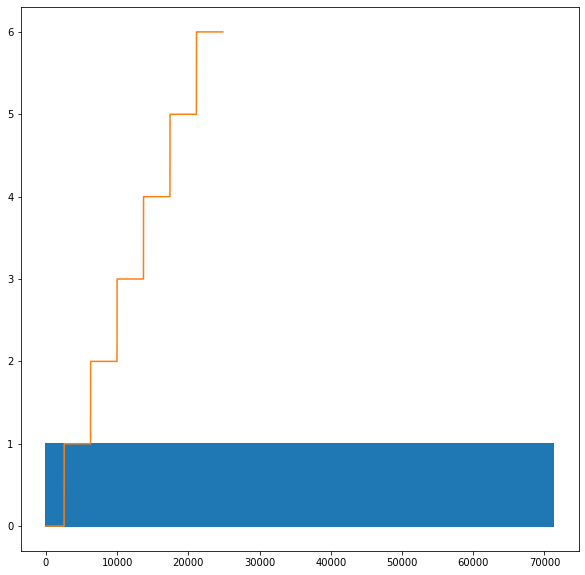

In [33]:
plt.figure(figsize=(10,10))
plt.plot(result_dict['y_eval'])
plt.plot(result_dict['y_dev_orig'] )

In [ ]:
computed

In [ ]:
total